<a href="https://colab.research.google.com/github/zzaeyun/ESAA23_1/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_127to154.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> CHAPTER 3 분류

## **3.1 MNIST**

MNIST 데이터셋
- 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70000개의 작은 숫자 이미지
- 각 이미지가 어떤 숫자를 나타내는지 레이블되어 있음




In [1]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 데이터셋들은 일반적으로 비슷한 딕셔너리 구조
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키


In [4]:
X,y=mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


- 이미지가 28x28 픽셀이므로 784개의 특성이 있음
- 개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄
- 맷플롯립의 imshow() 함수를 사용하여 이미지를 그릴 수 있음

In [8]:
import numpy as np

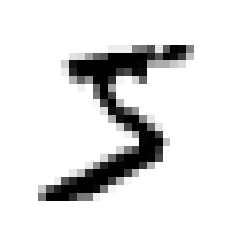

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X.iloc[0]
some_digit_image=np.array(some_digit).reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [10]:
y.iloc[0]
# 이미지와 일치

'5'

In [12]:
# 레이블은 문자열로 입력되어 있으므로 y를 정수로 변환

y=y.astype(np.uint8)

! 데이터를 조사하기 전에는 항상 테스트 세트를 만들고 따로 떼어놓아야함
- 훈련 세트는 앞쪽 60000개, 테스트 세트는 뒤쪽 10000개

In [13]:
X_train,X_test,y_train,y_test=X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

- 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듬
- 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐
- 데이터셋을 섞으면 이런 문제를 방지할 수 있음



---

##**3.2 이진 분류기 훈련**
- 문제를 단순화하여 하나의 숫자 -> 5만 식별
- '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진분류기


In [14]:
 #분류 작업을 위한 타깃 벡터
 y_train_5=(y_train==5)
 y_test_5=(y_test==5)

- 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(SGD) 분류기로 시작
  - 매우 큰 데이터셋을 효율적으로 처리하는 장점
  - SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문

In [15]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

정확하게 맞춤!

---

##**3.3 성능 측정**

###**3.3.1 교차 검증을 사용한 정확도 측정**

- 교차 검증은 모델을 평가하기 좋은 방법
- 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있음
  - 이때는 교차 검증 기능을 직접 구현
  - 다음 코드는 사이킷런의 cross_val_score()함수와 거의 같은 작업을 수행하고 동일한 결과를 출력


In [21]:
#교차 검증 구현

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds=X_train.iloc[train_index]
  y_train_folds=y_train_5.iloc[train_index]
  X_test_fold=X_train.iloc[test_index]
  y_test_fold=y_train_5.iloc[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


- cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 통해 SGDClassifier 모델을 평가
  - k-겹 교차 검증은 훈련세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

- 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교

In [23]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self,X):
    return np.zeros((len(X),1), dtype=bool)

In [24]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

이렇게 해도 90% 이상의 정확도
- 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌
- 특히 불균형한 데이터셋을 다룰 때 더욱 그럼

###**3.3.2 오차 행렬**
- 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것
- 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
 - 테스트 세트를 사용하면 안됨
 - 대신 corss_val_predict() 함수를 사용

 

In [26]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환



---
- confusion_matrix() 함수를 사용해 오차 행렬을 만들기
- 타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 행은 실제 클래스
- 열은 예측한 클래스
- 완벽한 분류기는 주대각선만 0이 아닌 값
  - 진짜 음성: 53892
  - 거짓 양성: 687
  - 거짓 음성: 1891
  - 진짜 양성: 3530


In [28]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

**정밀도**

- TP: 진짜 양성
- FP: 거짓 양성

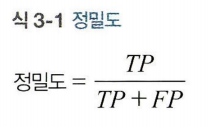

**재현율**
- 민감도 또는 진짜 양성 비율이라고도 부름
- FN: 거짓 음성


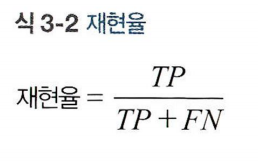

###**3.3.3 정밀도와 재현율**
- 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공

In [29]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- 정밀도와 재현율을 F1 점수라고 하는 하나의 숫자로 만들면 편리

**F1 점수**



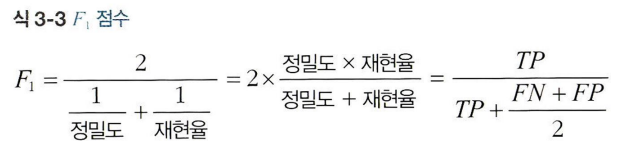

F1 점수를 계산하려면 f1_score() 함수를 호출

In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음
- 하지만 이것이 바람직한 것은 아님
  - 상황에 따라 정밀도가 중요할 수 있고 재현율이 중요할 수 있음
- 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지: 정밀도/재현율 트레이드 오프



---
###**3.3.4 정밀도/재현율 트레이드오프**

SGDClassifier가 분류를 결정하는 방법을 통해 트레이드 오프 이해
- 결정 함수를 사용하여 각 샘플의 점수를 계산
- 이때 낮은 점수부터 높은 점수까지 나열했을 때, 결정 임곗값에 따라 정밀도와 재현율이 달라짐
  - 임곗값을 올리면 재현율이 낮아지고 정밀도가 높아짐
  - 임곗값을 줄이면 재현율이 높아지고 정밀도가 줄어듬


- 사이킷런에서 임곗값을 직접 지정할 수 없지만 예측에 사용한 점수는 확인 가능
  - decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있음

In [32]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [35]:
#임곗값 0
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [36]:
#임곗값 8000
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

이처럼 임곗값에 따라 결과가 달라짐

---


**적절한 임곗값을 구하는 방법**
- 먼저 cross_val_predict() 함수를 사용하여 훈련 세트에 있는 모든 샘플의 점수를 구해야 함

In [37]:
y_scores=cross_val_predict(sgd_clf, X_train,y_train_5, cv=3, method='decision_function')

  - 이 점수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
   - precision_recall_curve() 함수를 사용

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

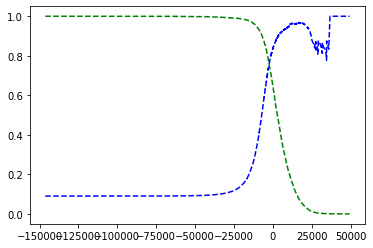

In [41]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g--', label='재현율')
  [...]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

**좋은 정밀도/재현율 트레이드 오프를 선택하는 다른 방법**
- 재현율에 대한 정밀도 곡선 그리기

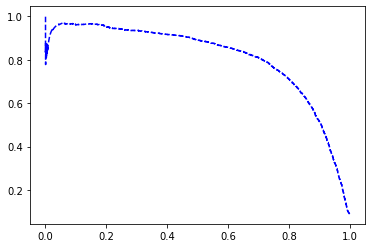

In [42]:
plt.plot(recalls[:-1], precisions[:-1], 'b--')

재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작
- 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음
  - 이는 프로젝트에 따라 선택이 달라질 수 있음

ex) 정밀도 90%를 달성하는 것이 목표
-> 최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있음

In [43]:
#np.argmax는 최댓값의 첫 번째 인덱스를 반환
threshold_90_precision=thresholds[np.argmax(precisions>= 0.90)]

In [44]:
y_train_pred_90=(y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

###**3.3.5 ROC 곡선**
- 수신기 조작 특성(ROC) 곡선: 이진 분류에서 널리 사용
- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
- TPR=1-TNR(진짜 음성 비율, 특이도)

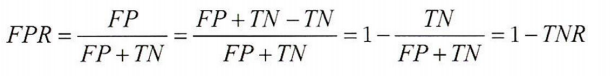

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

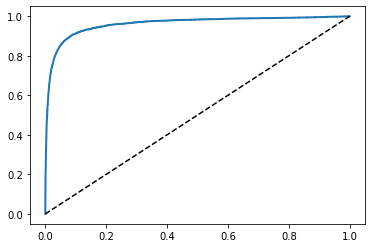

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  [...]

plot_roc_curve(fpr, tpr)
plt.show()

- 재현율이 높을수록 분류기를 만드는 거짓 양성이 늘어남
- 점선은 완전한 랜덤 분류기의 ROC 곡선
  - 좋은 분류기는 이 점선에서 최대한 멀리 떨어져야 함

- 곡선 아래의 면적(AUC)를 측정하면 분류기들을 비교할 수 있음


In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교
- 훈련 세트의 샘플에 대한 점수: RandomForestClassifier는 predict_proba( ) 메서드를 사용


In [51]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5, cv=3, method='predict_proba')

In [52]:
#roc_curve 함수는 레이블과 점수를 기대, 하지만 점수 대신에 클래스 확률을 전달할 수 있음
y_scores_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5, y_scores_forest)

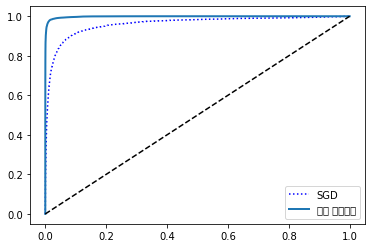

In [54]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest,'랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보임


In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

##**3.4 다중 분류**
- 다중 분류기(다항 분류기)는 둘 이상의 클래스를 구별
- SGD, 랜덤 포레스트, 나이브 베이즈: 여러 개의 클래스를 직접 처리
- 로지스틱 회귀, 서포트 벡터 머신: 이진 분류만 가능
  - 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음
  - **OvR(OvA)**: 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
  - **OvO**: 0과 1 구별, 0과 2 구별, 1과 2 구별과 같은 각 숫자 조합마다 이진 분류기를 훈련
  - 다중 클래스 부뉼 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행


In [57]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

- 위 코드는 5를 구별한 타깃 클래스 대신 0에서 9까지의 원래 타깃 클래스를 사용해 SVC를 훈련
- 그런 다음 예측 하나를 만듬
- 내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택
  - decision_function() 메서드를 호출하면 샘플당 10개의 점수 반환

In [58]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [59]:
np.argmax(some_digit_scores)

5

In [60]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [61]:
svm_clf.classes_[5]

5

- 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용


In [62]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local

array([5], dtype=uint8)

In [63]:
len(ovr_clf.estimators_)

10

SGD 또는 랜덤포레스트는 직접 다중 클래스로 분류할 수 있기 때문에 별도의 사이킷런의 OvR이나 OvO가 필요하지 않음

In [64]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [65]:
# 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 결과에서 분류기가 예측 결과에 대한 강한 확신을 보이고 있음을 알 수 있음
- 분류기 평가에는 일반적으로 교차 검증을 사용
  - cross_val_score() 함수를 사용

In [66]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

**간단하게 입력 스케일을 조정하면 정확도를 더욱 높일 수 있음**

In [67]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

##**3.5 에러 분석**
- 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법 찾기
- 그 중 한 가지 방법이 만들어진 에러의 종류를 분석하는 것
- confusion_matrix() 함수로 오차 행렬 살펴보기

In [68]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

- 많은 숫자가 출력되므로 matshow() 함수를 사용해 이미지로 표현

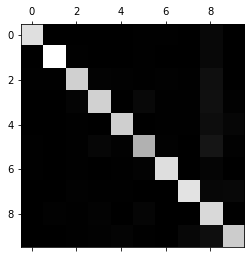

In [69]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 올바르게 분류되었음을 나타내는 주대각선에서 숫자 5가 다른 숫자보다 조금 더 어두워 보임
  - 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

1. 에러의 절대 개수가 아닌 에러 비율 비교
- 개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보임

In [70]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

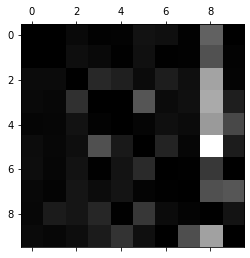

In [71]:
#다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

**여기서 분류기가 만든 에러를 확실히 확인 가능**
- 클래스 8의 열이 상당히 밝음 -> 많은 이미지가 8로 잘못 분류 됨
- 하지만 클래스 8의 행을 보면 실제 8이 적절히 8로 분류 되었음을 알 수 있음
- 3과 5가 서로 많이 혼동됨

**이처럼 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음**
- 8처럼 보이는 (실제로 8은 아닌) 숫자의 훈련 데이터를 더 많이 모아 실제 8과 구분하도록 분류기를 학습
  - 예를 들어 동심원의 수를 세는 알고리즘을 사용

3와 5의 샘플을 그려보고 왜 잘못되었는지에 대해 분석해보기

AttributeError: ignored

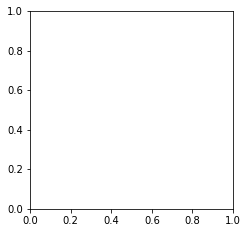

In [78]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    for instance in instances:
      images = [instance.reshape(size,size)]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3,5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 왼쪽 블럭 두 개: 3으로 분류된 이미지
- 오른쪽 블럭 두 개: 5로 분류된 이미지
- 대부분의 잘못 분류된 이미지는 에러인 것 같고 분류기가 실수한 이유를 이해하기 어려움: 원인은 SGDClassifier를 사용했기 때문
  - 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동
  - 분류기는 이미지의 위치나 회전 방향에 매우 민감하므로 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하면 에러가 줄어들 것
  

##**3.6 다중 레이블 분류**
- 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 경우
- ex) 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련: 앨리스, 찰리의 사진을 보고 [1, 0, 1]을 출력
- 이런 분류 시스템을 다중 레이블 분류 시스템

In [79]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

- 첫 번째: 숫자가 큰 값
- 두 번째: 홀수인지 

In [80]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

숫자 5는 크지 않고(False) 홀수(True)

다중 레이블 분류기를 평가하는 방법은 많음
- 적절한 지표는 프로젝트에 따라 다름
- ex) 모든 레이블에 대한 F1 점수의 평균 계산

In [81]:
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

\* 이 코드는 모든 레이블의 가중치가 같다고 가정한 것
- 앨리스의 사진이 밥이나 찰리보다 훨씬 많다면 레이블에 클래스의 지지도를 가중치로 주면 됨
  - 이전 코드에서 average='weighted'로 설정

---



##**3.7 다중 출력 분류**
- **다중 출력 다중 클래스 분류(다중 출력 분류)**: 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것
- ex) 이미지에서 잡음을 제거하는 시스템: 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
  - 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가짐(0~255)
  

MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에서 넘파이의 randint() 함수를 사용하여 픽셀 강도에 잡음을 추가

In [83]:
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod=X_train + noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test + noise
y_train_mod=X_train
y_test_mod=X_test

In [87]:
def plot_digit(data):
  image=np.array(data).reshape(28,28)
  plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
  plt.axis('off')

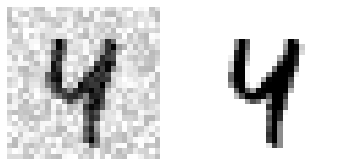

In [88]:
some_index=42

plt.subplot(121); plot_digit(X_test_mod.iloc[some_index])
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index])
plt.show()

분류기를 훈련시켜 이 이미지를 깨끗하게 만들기

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


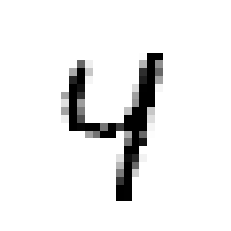

In [89]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digits(clean_digit)